In [1]:
# All the imports

from __future__ import print_function, division
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from keras import backend as K
from keras.layers import Layer

import copy

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from scipy.io import loadmat
from scipy.io import savemat

from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy




#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time

Using TensorFlow backend.


In [9]:
# Helper Functions

def unet_3d_prelu(input_size = (104, 56, 40, 1)):
    
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    
    zfilter = 40
    
    inputs = Input(input_size)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling3D(pool_size=(2, 2,2))(conv3)
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)

    up3    = UpSampling3D(size = (2,2,2))(conv4)
    merge3 = Add()([up3, conv3])
    merge3 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge3)
    merge3 = ReLU()(merge3)
    merge3 = BatchNormalization()(merge3)    
    
    up2    = UpSampling3D(size = (2,2,2))(merge3)
    merge2 = Add()([up2, conv2])
    merge2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge2)
    merge2 = ReLU()(merge2)
    merge2 = BatchNormalization()(merge2)    
    
    up1    = UpSampling3D(size = (2,2,2))(merge2)
    merge1 = Add()([up1, conv1])
    merge1 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    merge1 = ReLU()(merge1)
    merge1 = BatchNormalization()(merge1)    
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up7)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return model

def unet_3d_prelu2(input_size = (56, 56, 40, 1)):
    
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    
    zfilter = 3
    
    inputs = Input(input_size)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling3D(pool_size=(2, 2,2))(conv3)
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)

    up3    = UpSampling3D(size = (2,2,2))(conv4)
    merge3 = Add()([up3, conv3])
    merge3 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge3)
    merge3 = ReLU()(merge3)
    merge3 = BatchNormalization()(merge3)    
    
    up2    = UpSampling3D(size = (2,2,2))(merge3)
    merge2 = Add()([up2, conv2])
    merge2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge2)
    merge2 = ReLU()(merge2)
    merge2 = BatchNormalization()(merge2)    
    
    up1    = UpSampling3D(size = (2,2,2))(merge2)
    merge1 = Add()([up1, conv1])
    merge1 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    merge1 = ReLU()(merge1)
    merge1 = BatchNormalization()(merge1)    
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    up7 = BatchNormalization()(up7)
    
    up8 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up7)
    up8 = ReLU()(up8)
    up8 = BatchNormalization()(up8)
    
    up8 = Add()([up8, merge1])
    
    up9 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up8)
    up9 = ReLU()(up9)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0002), loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    return model

def unet_3d_prelu1(input_size = (104, 56, 40, 1)):
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    zfilter = 40
    
    model = load_model('/media/dril/ubuntudata/DBT-NEW/models/model2.h5', compile=False)
    x     = model.layers[-3].output
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(x)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up7)
    up7 = ReLU()(up7)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up7)
    conv9 = ReLU()(conv9)
    
    model1 = Model(input = model.input, output = conv9)
    model1.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['mae'])
    
    model3 =  load_model('/media/dril/ubuntudata/DBT-NEW/models/model2.h5', compile=False)
    
    for i in range(len(model3.layers)-2):
        if len(model3.layers[i].get_weights()) > 0:
            model1.layers[i].set_weights(model3.layers[i].get_weights())
    
    return model1

def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

# For checking if weights are same or not of two networks

# for i in range(40):
#     w1 = model3.layers[i].get_weights()
#     w2 = m2.layers[i].get_weights()
    
#     for j in range(len(w1)):
#         print(i, np.all(w1[j] == w2[j]))

In [ ]:
# For getting the shapes

allshapesx = []
allshapesy = []
allshapesz = []

for i in range(1, 177):
    a = loadmat('/media/dril/ubuntudata/attenuation_values/'+str(i)+'.mat')
    a = a['head']
    b = copy.deepcopy(a)
    a[a != 0 ] = 1
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(a)
    b = b[rmin:rmax, cmin:cmax, zmin:zmax]
    
    allshapesx.append(b.shape[0])
    allshapesy.append(b.shape[1])
    allshapesz.append(b.shape[2])
    
    temp = int((800-b.shape[0])/2)
    vol = b
    vol = np.pad(b, ((temp, 800-temp-b.shape[0]), (320-b.shape[1], 0), (0, 448-b.shape[2])), 
                     'constant', constant_values=(0, 0))
    vol = np.moveaxis(vol, [1, 2], [2, 1]).astype(np.single)

    h = {}
    h['head'] = vol
    savemat('/media/dril/ubuntudata/attenuation_values_cropped/'+str(i)+'.mat', h,
            do_compression=True)
    print(i, vol.shape)

In [ ]:
# New size will be 800, 320, 448

In [ ]:
# For reading the data for training the 3D U-Net model

trainx = []
trainy = []
valx   = []
valy   = []

for i in range(1, 177):
    volx = loadmat('/media/dril/ubuntudata/DBT-NEW/recons/sart_cir_zero_'+str(i)+'.mat')
    voly = loadmat('/media/dril/ubuntudata/DBT-NEW/attenuation_values_cropped/'+str(i)+'.mat')
    
    volx = volx['xartt']
    voly = voly['head']
    
    voly = ndimage.zoom(voly, 0.0625, order=1).astype(np.single)
    volx = ndimage.zoom(volx, 0.125, order=1).astype(np.single)
    
    if i <= 140:
        trainx.append(np.expand_dims(volx, axis=-1))
        trainy.append(np.expand_dims(voly, axis=-1))
    else:
        valx.append(np.expand_dims(volx,axis=-1))
        valy.append(np.expand_dims(voly,axis=-1))

trainx = np.array(trainx)
trainy = np.array(trainy)
valx   = np.array(valx)
valy   = np.array(valy)

# trainx  = np.pad(trainx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
# trainy  = np.pad(trainy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
# valx    = np.pad(valx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
# valy    = np.pad(valy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))

print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)

In [ ]:
# For reading the data for training the 3D U-Net model in small patches

trainx = []
trainy = []
valx   = []
valy   = []

for i in range(1, 177):
    print(i)
    volx = loadmat('/media/pranjal/Backup/DBT-NEW/recons/sart_cir_zero_'+str(i)+'.mat')
    voly = loadmat('/media/pranjal/Backup/DBT-NEW/attenuation_values_cropped/'+str(i)+'.mat')
    
    volx = volx['xartt']
    voly = voly['head']
    
    voly = ndimage.zoom(voly, 0.125, order=1).astype(np.single)
    volx = ndimage.zoom(volx, 0.250, order=1).astype(np.single)
    
    #print(volx.shape)
    x1 = volx[:50, :, :]
    x2 = volx[50:, :, :]
    x3 = volx[25:75, :, :]
    x4 = volx[35:85, :, :]
    x5 = volx[15:65, :, :]

    y1 = voly[:50, :, :]
    y2 = voly[50:, :, :]
    y3 = voly[25:75, :, :]
    y4 = voly[35:85, :, :]
    y5 = voly[15:65, :, :]
        
    if i <= 140:
        trainx.append(np.expand_dims(x1, axis=-1))
        trainx.append(np.expand_dims(x2, axis=-1))
        trainx.append(np.expand_dims(x3, axis=-1))
        trainx.append(np.expand_dims(x4, axis=-1))
        trainx.append(np.expand_dims(x5, axis=-1))
        
        trainy.append(np.expand_dims(y1, axis=-1))
        trainy.append(np.expand_dims(y2, axis=-1))
        trainy.append(np.expand_dims(y3, axis=-1))
        trainy.append(np.expand_dims(y4, axis=-1))
        trainy.append(np.expand_dims(y5, axis=-1))
    else:
        valx.append(np.expand_dims(x1, axis=-1))
        valx.append(np.expand_dims(x2, axis=-1))
        valx.append(np.expand_dims(x3, axis=-1))
        valx.append(np.expand_dims(x4, axis=-1))
        valx.append(np.expand_dims(x5, axis=-1))
        
        valy.append(np.expand_dims(y1, axis=-1))
        valy.append(np.expand_dims(y2, axis=-1))
        valy.append(np.expand_dims(y3, axis=-1))
        valy.append(np.expand_dims(y4, axis=-1))
        valy.append(np.expand_dims(y5, axis=-1))

trainx = np.array(trainx)
trainy = np.array(trainy)
valx   = np.array(valx)
valy   = np.array(valy)

trainx  = np.pad(trainx, ((0,0), (3, 3), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
trainy  = np.pad(trainy, ((0,0), (3, 3), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valx    = np.pad(valx, ((0,0), (3, 3), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valy    = np.pad(valy, ((0,0), (3, 3), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))

print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)

In [10]:
# For training the U-Net model

checkpoint  = ModelCheckpoint(filepath='/media/pranjal/Backup/DBT-NEW/models/model9-cewit.h5', 
                              monitor='val_loss', period=10, 
                              verbose=1, save_best_only=True, mode='min')
model = unet_3d_prelu2()
model.fit(trainx, trainy, validation_data=(valx, valy), 
          batch_size=4, 
          epochs=1500, callbacks=[checkpoint])

Train on 700 samples, validate on 180 samples
Epoch 1/1500
700/700 [==============================] - 23s 33ms/step - loss: 0.1775 - mean_squared_error: 0.1816 - val_loss: 0.0820 - val_mean_squared_error: 0.0321
Epoch 2/1500
700/700 [==============================] - 22s 31ms/step - loss: 0.0696 - mean_squared_error: 0.0256 - val_loss: 0.0598 - val_mean_squared_error: 0.0221
Epoch 3/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0584 - mean_squared_error: 0.0205 - val_loss: 0.0509 - val_mean_squared_error: 0.0184
Epoch 4/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0526 - mean_squared_error: 0.0177 - val_loss: 0.0539 - val_mean_squared_error: 0.0177
Epoch 5/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0489 - mean_squared_error: 0.0162 - val_loss: 0.0508 - val_mean_squared_error: 0.0184
Epoch 6/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0464 - mean_squared_error: 0.0151 - val_loss

Epoch 47/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0265 - mean_squared_error: 0.0067 - val_loss: 0.0278 - val_mean_squared_error: 0.0085
Epoch 48/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0270 - mean_squared_error: 0.0069 - val_loss: 0.0281 - val_mean_squared_error: 0.0088
Epoch 49/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0260 - mean_squared_error: 0.0065 - val_loss: 0.0274 - val_mean_squared_error: 0.0084
Epoch 50/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0257 - mean_squared_error: 0.0064 - val_loss: 0.0277 - val_mean_squared_error: 0.0085

Epoch 00050: val_loss improved from 0.02818 to 0.02767, saving model to /media/pranjal/Backup/DBT-NEW/models/model9-cewit.h5
Epoch 51/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0259 - mean_squared_error: 0.0065 - val_loss: 0.0278 - val_mean_squared_error: 0.0083
Epoch 52/1500
700/700 [================

Epoch 93/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0225 - mean_squared_error: 0.0053 - val_loss: 0.0257 - val_mean_squared_error: 0.0078
Epoch 94/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0225 - mean_squared_error: 0.0053 - val_loss: 0.0253 - val_mean_squared_error: 0.0077
Epoch 95/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0222 - mean_squared_error: 0.0053 - val_loss: 0.0259 - val_mean_squared_error: 0.0077
Epoch 96/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0222 - mean_squared_error: 0.0052 - val_loss: 0.0257 - val_mean_squared_error: 0.0078
Epoch 97/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0220 - mean_squared_error: 0.0052 - val_loss: 0.0262 - val_mean_squared_error: 0.0078
Epoch 98/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0219 - mean_squared_error: 0.0051 - val_loss: 0.0251 - val_mean_squared_error: 0.007

Epoch 140/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0200 - mean_squared_error: 0.0043 - val_loss: 0.0251 - val_mean_squared_error: 0.0075

Epoch 00140: val_loss did not improve from 0.02502
Epoch 141/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0210 - mean_squared_error: 0.0046 - val_loss: 0.0251 - val_mean_squared_error: 0.0077
Epoch 142/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0201 - mean_squared_error: 0.0044 - val_loss: 0.0245 - val_mean_squared_error: 0.0073
Epoch 143/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0198 - mean_squared_error: 0.0043 - val_loss: 0.0246 - val_mean_squared_error: 0.0074
Epoch 144/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0197 - mean_squared_error: 0.0042 - val_loss: 0.0250 - val_mean_squared_error: 0.0074
Epoch 145/1500
700/700 [==============================] - 23s 32ms/step - loss: 0.0198 - mean_squared_error:

700/700 [==============================] - 22s 32ms/step - loss: 0.0189 - mean_squared_error: 0.0039 - val_loss: 0.0246 - val_mean_squared_error: 0.0073
Epoch 187/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0186 - mean_squared_error: 0.0038 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 188/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0184 - mean_squared_error: 0.0038 - val_loss: 0.0252 - val_mean_squared_error: 0.0075
Epoch 189/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0185 - mean_squared_error: 0.0038 - val_loss: 0.0246 - val_mean_squared_error: 0.0073
Epoch 190/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0185 - mean_squared_error: 0.0038 - val_loss: 0.0246 - val_mean_squared_error: 0.0074

Epoch 00190: val_loss improved from 0.02489 to 0.02460, saving model to /media/pranjal/Backup/DBT-NEW/models/model9-cewit.h5
Epoch 191/1500
700/700 [=========================

Epoch 232/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0176 - mean_squared_error: 0.0035 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 233/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0177 - mean_squared_error: 0.0035 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 234/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0177 - mean_squared_error: 0.0035 - val_loss: 0.0245 - val_mean_squared_error: 0.0073
Epoch 235/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0176 - mean_squared_error: 0.0035 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 236/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0177 - mean_squared_error: 0.0035 - val_loss: 0.0252 - val_mean_squared_error: 0.0075
Epoch 237/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0177 - mean_squared_error: 0.0035 - val_loss: 0.0246 - val_mean_squared_error:

700/700 [==============================] - 22s 32ms/step - loss: 0.0168 - mean_squared_error: 0.0033 - val_loss: 0.0246 - val_mean_squared_error: 0.0074
Epoch 280/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0171 - mean_squared_error: 0.0034 - val_loss: 0.0241 - val_mean_squared_error: 0.0073

Epoch 00280: val_loss improved from 0.02434 to 0.02415, saving model to /media/pranjal/Backup/DBT-NEW/models/model9-cewit.h5
Epoch 281/1500
700/700 [==============================] - 22s 31ms/step - loss: 0.0171 - mean_squared_error: 0.0033 - val_loss: 0.0255 - val_mean_squared_error: 0.0075
Epoch 282/1500
700/700 [==============================] - 22s 31ms/step - loss: 0.0171 - mean_squared_error: 0.0033 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 283/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0169 - mean_squared_error: 0.0033 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 284/1500
700/700 [=========================

Epoch 326/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0165 - mean_squared_error: 0.0032 - val_loss: 0.0243 - val_mean_squared_error: 0.0074
Epoch 327/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0166 - mean_squared_error: 0.0032 - val_loss: 0.0246 - val_mean_squared_error: 0.0075
Epoch 328/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0166 - mean_squared_error: 0.0032 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 329/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0165 - mean_squared_error: 0.0032 - val_loss: 0.0254 - val_mean_squared_error: 0.0078
Epoch 330/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0165 - mean_squared_error: 0.0032 - val_loss: 0.0244 - val_mean_squared_error: 0.0073

Epoch 00330: val_loss did not improve from 0.02415
Epoch 331/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0165 - mean_squared_error:

700/700 [==============================] - 22s 32ms/step - loss: 0.0162 - mean_squared_error: 0.0031 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 374/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0161 - mean_squared_error: 0.0031 - val_loss: 0.0246 - val_mean_squared_error: 0.0073
Epoch 375/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0162 - mean_squared_error: 0.0031 - val_loss: 0.0243 - val_mean_squared_error: 0.0073
Epoch 376/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0163 - mean_squared_error: 0.0031 - val_loss: 0.0246 - val_mean_squared_error: 0.0074
Epoch 377/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0161 - mean_squared_error: 0.0031 - val_loss: 0.0243 - val_mean_squared_error: 0.0074
Epoch 378/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0161 - mean_squared_error: 0.0031 - val_loss: 0.0243 - val_mean_squared_error: 0.0074
Epoch 3

700/700 [==============================] - 22s 32ms/step - loss: 0.0159 - mean_squared_error: 0.0030 - val_loss: 0.0244 - val_mean_squared_error: 0.0073

Epoch 00420: val_loss did not improve from 0.02415
Epoch 421/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0159 - mean_squared_error: 0.0030 - val_loss: 0.0245 - val_mean_squared_error: 0.0073
Epoch 422/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0160 - mean_squared_error: 0.0030 - val_loss: 0.0245 - val_mean_squared_error: 0.0073
Epoch 423/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0160 - mean_squared_error: 0.0030 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 424/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0159 - mean_squared_error: 0.0030 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 425/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0158 - mean_squared_error: 0.0030 - val_l

Epoch 467/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0157 - mean_squared_error: 0.0029 - val_loss: 0.0246 - val_mean_squared_error: 0.0073
Epoch 468/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0158 - mean_squared_error: 0.0029 - val_loss: 0.0245 - val_mean_squared_error: 0.0074
Epoch 469/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0156 - mean_squared_error: 0.0029 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 470/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0157 - mean_squared_error: 0.0029 - val_loss: 0.0245 - val_mean_squared_error: 0.0073

Epoch 00470: val_loss did not improve from 0.02412
Epoch 471/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0156 - mean_squared_error: 0.0029 - val_loss: 0.0243 - val_mean_squared_error: 0.0073
Epoch 472/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0156 - mean_squared_error:

Epoch 514/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0155 - mean_squared_error: 0.0029 - val_loss: 0.0241 - val_mean_squared_error: 0.0073
Epoch 515/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0155 - mean_squared_error: 0.0029 - val_loss: 0.0248 - val_mean_squared_error: 0.0074
Epoch 516/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0155 - mean_squared_error: 0.0029 - val_loss: 0.0241 - val_mean_squared_error: 0.0073
Epoch 517/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0155 - mean_squared_error: 0.0029 - val_loss: 0.0241 - val_mean_squared_error: 0.0073
Epoch 518/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0154 - mean_squared_error: 0.0029 - val_loss: 0.0246 - val_mean_squared_error: 0.0075
Epoch 519/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0154 - mean_squared_error: 0.0029 - val_loss: 0.0242 - val_mean_squared_error:

700/700 [==============================] - 22s 32ms/step - loss: 0.0152 - mean_squared_error: 0.0028 - val_loss: 0.0242 - val_mean_squared_error: 0.0073
Epoch 562/1500
700/700 [==============================] - 22s 31ms/step - loss: 0.0151 - mean_squared_error: 0.0028 - val_loss: 0.0245 - val_mean_squared_error: 0.0073
Epoch 563/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0153 - mean_squared_error: 0.0028 - val_loss: 0.0242 - val_mean_squared_error: 0.0073
Epoch 564/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0152 - mean_squared_error: 0.0028 - val_loss: 0.0244 - val_mean_squared_error: 0.0072
Epoch 565/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0154 - mean_squared_error: 0.0028 - val_loss: 0.0241 - val_mean_squared_error: 0.0073
Epoch 566/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0151 - mean_squared_error: 0.0028 - val_loss: 0.0246 - val_mean_squared_error: 0.0074
Epoch 5

700/700 [==============================] - 22s 31ms/step - loss: 0.0151 - mean_squared_error: 0.0028 - val_loss: 0.0244 - val_mean_squared_error: 0.0073
Epoch 609/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0150 - mean_squared_error: 0.0027 - val_loss: 0.0250 - val_mean_squared_error: 0.0073
Epoch 610/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0151 - mean_squared_error: 0.0027 - val_loss: 0.0243 - val_mean_squared_error: 0.0073

Epoch 00610: val_loss did not improve from 0.02410
Epoch 611/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0152 - mean_squared_error: 0.0028 - val_loss: 0.0242 - val_mean_squared_error: 0.0073
Epoch 612/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0150 - mean_squared_error: 0.0027 - val_loss: 0.0241 - val_mean_squared_error: 0.0073
Epoch 613/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0151 - mean_squared_error: 0.0027 - val_l

700/700 [==============================] - 22s 32ms/step - loss: 0.0149 - mean_squared_error: 0.0027 - val_loss: 0.0248 - val_mean_squared_error: 0.0073
Epoch 656/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0149 - mean_squared_error: 0.0027 - val_loss: 0.0242 - val_mean_squared_error: 0.0073
Epoch 657/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0148 - mean_squared_error: 0.0027 - val_loss: 0.0242 - val_mean_squared_error: 0.0073
Epoch 658/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0150 - mean_squared_error: 0.0027 - val_loss: 0.0243 - val_mean_squared_error: 0.0073
Epoch 659/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0150 - mean_squared_error: 0.0027 - val_loss: 0.0243 - val_mean_squared_error: 0.0073
Epoch 660/1500
700/700 [==============================] - 22s 32ms/step - loss: 0.0149 - mean_squared_error: 0.0027 - val_loss: 0.0243 - val_mean_squared_error: 0.0073

Epoch 

KeyboardInterrupt: 

In [12]:
model = load_model('/media/pranjal/Backup/DBT-NEW/models/model9-cewit.h5', compile=False)

In [15]:
model1 = load_model('/media/pranjal/Backup/DBT-NEW/models/model3.h5', compile=False)

In [13]:
result = model.predict(valx, batch_size=4)
print(result.shape)

(180, 56, 56, 40, 1)


In [ ]:
result1 = model1.predict(valx, batch_size=4)
print(result1.shape)

32


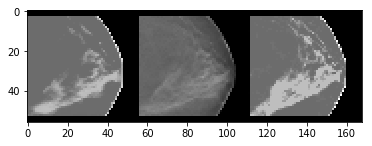

In [21]:
index = random.randint(0, 35)
print(index)
slicenum = 20
plt.imshow(np.concatenate([result[index, :, :, slicenum, 0], valx[index, :, :, slicenum, 0], valy[index, :, :, slicenum, 0]], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([result[index, :, :, slicenum, 0], valx[index, :, :, slicenum, 0], valy[index, :, :, slicenum, 0]], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([result[index, :, :, slicenum, 0], valx[index, :, :, slicenum, 0], valy[index, :, :, slicenum, 0]], axis=-1), cmap='gray')

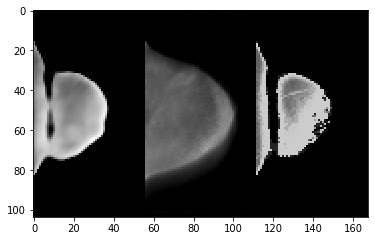

In [90]:
plt.imshow(np.concatenate([result1[index, :, :, slicenum, 0], valx[index, :, :, slicenum, 0], valy[index, :, :, slicenum, 0]], axis=-1), cmap='gray')

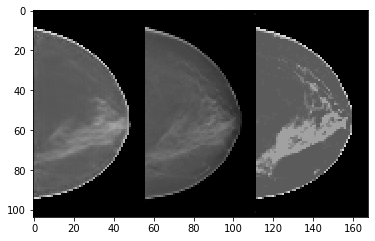

In [56]:
index = random.randint(0, 35)
print(index)
plt.imshow(np.concatenate([result[index, :, :, 20, 0], valx[index, :, :, 20, 0], valy[index, :, :, 20, 0]], axis=-1), cmap='gray')

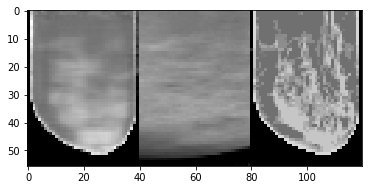

In [73]:
index = random.randint(0, 35)
plt.imshow(np.concatenate([result[index, 50, :, :, 0], valx[index, 50, :, :, 0], valy[index, 50, :, :, 0]], axis=-1), cmap='gray')